In [296]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer

import copy
import operator
import datetime
import warnings
from itertools import product
warnings.filterwarnings("ignore")



In [297]:
TRAIN_SIZE = 100000
#we'll not be using the full training set, change this parameter if you wish to use more/less
train = pd.read_csv("interactions_train.csv")
validation = pd.read_csv("interactions_validation.csv")
raw = pd.read_csv("RAW_recipes.csv")
r_calory = pd.read_csv("PP_recipes.csv")
raw = raw.rename({"id":"recipe_id"},axis=1)
interactions_RAW = pd.read_csv("RAW_interactions.csv")

#since we'll be using k-fold validation, there is not need to use a seperate validation set
train = pd.concat([train,validation],axis=0)
test = pd.read_csv("interactions_test.csv")
train = train.iloc[:TRAIN_SIZE,:]

In [298]:
train = train.merge(interactions_RAW.drop(["rating","date"],axis=1),on=["user_id","recipe_id"])
train = train.merge(raw,on="recipe_id")
test = test.merge(interactions_RAW.drop(["rating","date"],axis=1),on=["user_id","recipe_id"])
test = test.merge(raw,on="recipe_id")
train.head(2)
raw1=pd.merge(raw,r_calory,left_on="recipe_id",right_on="id",how="right")
raw.head(2)

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6


,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6


In [299]:
interactions_RAW.head(2)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


In [300]:
interactions_RAW.drop(['date','review'],axis=1)

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5
...,...,...,...
1132362,116593,72730,0
1132363,583662,386618,5
1132364,157126,78003,5
1132365,53932,78003,4


,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5
...,...,...,...
1132362,116593,72730,0
1132363,583662,386618,5
1132364,157126,78003,5
1132365,53932,78003,4


In [301]:
raw1.drop(['name','minutes','contributor_id','submitted','tags','steps','description','ingredient_ids','i','name_tokens','ingredient_tokens','steps_tokens','techniques','id','n_steps'], axis=1)

,recipe_id,nutrition,ingredients,n_ingredients,calorie_level
0,137739,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]","['winter squash', 'mexican seasoning', 'mixed ...",7,0
1,31490,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]","['prepared pizza crust', 'sausage patty', 'egg...",6,0
2,59389,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]","['spreadable cheese with garlic and herbs', 'n...",11,1
3,5289,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]","['milk', 'vanilla ice cream', 'frozen apple ju...",4,0
4,25274,"[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]","['fennel seeds', 'green olives', 'ripe olives'...",9,1
...,...,...,...,...,...
178260,185979,"[103.1, 2.0, 39.0, 97.0, 11.0, 0.0, 7.0]","['garlic cloves', 'yellow mustard seeds', 'fre...",8,0
178261,367912,"[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]","['iceberg lettuce', 'tomatoes', '3 bean mix', ...",4,0
178262,357451,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]","['mayonnaise', 'prepared horseradish', 'worces...",6,0
178263,188810,"[482.6, 13.0, 25.0, 37.0, 33.0, 9.0, 27.0]","['white rice', 'vegetable oil', 'onion', 'gree...",11,1


,recipe_id,nutrition,ingredients,n_ingredients,calorie_level
0,137739,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]","['winter squash', 'mexican seasoning', 'mixed ...",7,0
1,31490,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]","['prepared pizza crust', 'sausage patty', 'egg...",6,0
2,59389,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]","['spreadable cheese with garlic and herbs', 'n...",11,1
3,5289,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]","['milk', 'vanilla ice cream', 'frozen apple ju...",4,0
4,25274,"[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]","['fennel seeds', 'green olives', 'ripe olives'...",9,1
...,...,...,...,...,...
178260,185979,"[103.1, 2.0, 39.0, 97.0, 11.0, 0.0, 7.0]","['garlic cloves', 'yellow mustard seeds', 'fre...",8,0
178261,367912,"[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]","['iceberg lettuce', 'tomatoes', '3 bean mix', ...",4,0
178262,357451,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]","['mayonnaise', 'prepared horseradish', 'worces...",6,0
178263,188810,"[482.6, 13.0, 25.0, 37.0, 33.0, 9.0, 27.0]","['white rice', 'vegetable oil', 'onion', 'gree...",11,1


In [302]:
raw1.iloc[0:50000]

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,137739,145702,"[40480, 1943, 6987, 12187, 4423, 23841, 12432,...","[[4423, 23841], [12432, 29471, 484], [5811, 16...","[40480, 40482, 925, 246, 2650, 488, 10744, 556...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,31490,33090,"[40480, 246, 1378, 1685, 3511, 6856, 40481]","[[3572, 6856, 19093], [17027, 15774], [6812], ...","[40480, 40482, 729, 2525, 10906, 485, 44, 1035...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,59389,44921,"[40480, 501, 482, 3561, 10837, 40481]","[[582, 14754, 6821, 556, 15022, 488, 13747], [...","[40480, 40482, 1082, 10837, 500, 246, 1719, 50...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,5289,28162,"[40480, 7304, 246, 850, 5940, 3033, 40481]","[[5940], [15000, 755, 4914], [4787, 7304, 7524...","[40480, 40482, 23667, 16126, 500, 37588, 40478...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,25274,140021,"[40480, 30192, 831, 21375, 30142, 40481]","[[8352, 3098, 14516], [2056, 30142], [13583, 3...","[40480, 40482, 8061, 481, 8352, 3098, 14516, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,crispy buttermilk chicken,434734,40,800297,2010-08-10,"['60-minutes-or-less', 'time-to-make', 'course...","[2818.3, 419.0, 25.0, 39.0, 129.0, 220.0, 10.0]",8,"['in a bowl , blend first 4 ingredients', 'in ...",this is a great version of fried chicken and g...,"['garlic powder', 'salt', 'thyme', 'worcesters...",9,434734,46088,"[40480, 33620, 6796, 5940, 5867, 40481]","[[15022, 8361], [6953], [20930, 510], [652, 25...","[40480, 40482, 500, 246, 5024, 240, 12172, 929...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[3217, 6270, 7168, 7946, 3486, 869, 7819, 2683..."
49996,crispy buttermilk waffles,200498,490,311861,2006-12-14,"['course', 'pancakes-and-waffles', 'breakfast']","[568.4, 47.0, 15.0, 22.0, 28.0, 91.0, 19.0]",13,['prepare the batter and refrigerate at least ...,these waffles are amazing! they are so crispy...,"['flour', 'instant yeast', 'butter', 'milk', '...",8,200498,50522,"[40480, 33620, 67

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,137739,145702,"[40480, 1943, 6987, 12187, 4423, 23841, 12432,...","[[4423, 23841], [12432, 29471, 484], [5811, 16...","[40480, 40482, 925, 246, 2650, 488, 10744, 556...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,31490,33090,"[40480, 246, 1378, 1685, 3511, 6856, 40481]","[[3572, 6856, 19093], [17027, 15774], [6812], ...","[40480, 40482, 729, 2525, 10906, 485, 44, 1035...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,59389,44921,"[40480, 501, 482, 3561, 10837, 40481]","[[582, 14754, 6821, 556, 15022, 488, 13747], [...","[40480, 40482, 1082, 10837, 500, 246, 1719, 50...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,5289,28162,"[40480, 7304, 246, 850, 5940, 3033, 40481]","[[5940], [15000, 755, 4914], [4787, 7304, 7524...","[40480, 40482, 23667, 16126, 500, 37588, 40478...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,25274,140021,"[40480, 30192, 831, 21375, 30142, 40481]","[[8352, 3098, 14516], [2056, 30142], [13583, 3...","[40480, 40482, 8061, 481, 8352, 3098, 14516, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,crispy buttermilk chicken,434734,40,800297,2010-08-10,"['60-minutes-or-less', 'time-to-make', 'course...","[2818.3, 419.0, 25.0, 39.0, 129.0, 220.0, 10.0]",8,"['in a bowl , blend first 4 ingredients', 'in ...",this is a great version of fried chicken and g...,"['garlic powder', 'salt', 'thyme', 'worcesters...",9,434734,46088,"[40480, 33620, 6796, 5940, 5867, 40481]","[[15022, 8361], [6953], [20930, 510], [652, 25...","[40480, 40482, 500, 246, 5024, 240, 12172, 929...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[3217, 6270, 7168, 7946, 3486, 869, 7819, 2683..."
49996,crispy buttermilk waffles,200498,490,311861,2006-12-14,"['course', 'pancakes-and-waffles', 'breakfast']","[568.4, 47.0, 15.0, 22.0, 28.0, 91.0, 19.0]",13,['prepare the batter and refrigerate at least ...,these waffles are amazing! they are so crispy...,"['flour', 'instant yeast', 'butter', 'milk', '...",8,200498,50522,"[40480, 33620, 67

In [303]:
recipes=raw1['recipe_id']

In [304]:
k=list(recipes)

In [305]:
k.index(5289)

3

3

In [306]:
import pandas as pd
from surprise import Dataset
from surprise import Reader

# This is the same data that was plotted for similarity earlier
# with one new user "E" who has rated only movie 1
ratings_dict = interactions_RAW

df = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(0, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user_id", "recipe_id", "rating"]], reader)
# Loads the builtin Movielens-100k data


In [307]:
interactions=interactions_RAW.iloc[0:50000]

In [308]:
interactions=interactions.drop(['date','review'], axis=1)

In [309]:
interactions

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5
...,...,...,...
49995,75681,67192,5
49996,104215,67192,5
49997,29063,67192,5
49998,62086,67192,5


,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5
...,...,...,...
49995,75681,67192,5
49996,104215,67192,5
49997,29063,67192,5
49998,62086,67192,5


In [310]:
df_features = interactions.pivot(
    index='user_id',
    columns='recipe_id',
    values='rating'
).fillna(0)

In [311]:
df_features

recipe_id,39,147,174,210,232,236,355,360,376,503,...,532629,533575,533865,533919,534722,534896,535300,536455,536583,537037
user_id,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002365627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002368192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002369208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


recipe_id,39,147,174,210,232,236,355,360,376,503,...,532629,533575,533865,533919,534722,534896,535300,536455,536583,537037
user_id,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002365627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002368192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002369208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [312]:
type(df_features)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [313]:
recipes=list(df_features.columns)

In [314]:
users=list(df_features.index)

In [315]:
R = df_features.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [316]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [317]:
sigma = np.diag(sigma)

In [318]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [319]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_features.columns)
preds_df

recipe_id,39,147,174,210,232,236,355,360,376,503,...,532629,533575,533865,533919,534722,534896,535300,536455,536583,537037
0,0.004328,0.004329,0.004574,0.003733,0.003365,0.004446,0.004217,0.004329,0.002910,0.004499,...,0.000941,0.004329,0.004328,0.004328,0.004329,0.004328,0.004329,0.004329,0.004328,0.004328
1,0.009441,0.009415,0.010523,0.018002,0.046472,0.012104,0.015753,0.009374,0.170215,0.014205,...,0.050938,0.009374,0.009455,0.009429,0.009415,0.009447,0.009415,0.009415,0.009455,0.009455
2,-0.000175,-0.000177,-0.000170,0.000088,-0.000284,0.000122,-0.000081,-0.000179,0.012521,0.000175,...,-0.001405,-0.000179,-0.000175,-0.000176,-0.000177,-0.000175,-0.000177,-0.000177,-0.000175,-0.000175
3,-0.002034,-0.002038,-0.003673,-0.000438,-0.011411,-0.001469,-0.002403,-0.002044,0.023689,-0.001842,...,-0.002424,-0.002044,-0.002031,-0.002036,-0.002038,-0.002033,-0.002038,-0.002038,-0.002031,-0.002031
4,0.001486,0.001487,0.001415,0.002278,0.002106,0.001660,0.001667,0.001487,0.002864,0.001513,...,0.001416,0.001487,0.001486,0.001487,0.001487,0.001486,0.001487,0.001487,0.001486,0.001486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22584,0.000077,0.000079,0.000283,-0.000825,-0.004535,-0.000400,-0.000157,0.000081,-0.012758,-0.000181,...,-0.002320,0.000081,0.000076,0.000078,0.000079,0.000077,0.000079,0.000079,0.000076,0.000076
22585,0.000556,0.000556,0.000743,0.000341,0.001331,0.000565,0.000597,0.000557,-0.000039,0.000526,...,-0.000067,0.000557,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556
22586,-0.000497,-0.000499,-0.000584,-0.000847,-0.006185,-0.000276,0.000239,-0.000502,0.041956,-0.000342,...,-0.007647,-0.000502,-0.000495,-0.000498,-0.000499,-0.000496,-0.000499,-0.000499,-0.000495,-0.000495
22587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


recipe_id,39,147,174,210,232,236,355,360,376,503,...,532629,533575,533865,533919,534722,534896,535300,536455,536583,537037
0,0.004328,0.004329,0.004574,0.003733,0.003365,0.004446,0.004217,0.004329,0.002910,0.004499,...,0.000941,0.004329,0.004328,0.004328,0.004329,0.004328,0.004329,0.004329,0.004328,0.004328
1,0.009441,0.009415,0.010523,0.018002,0.046472,0.012104,0.015753,0.009374,0.170215,0.014205,...,0.050938,0.009374,0.009455,0.009429,0.009415,0.009447,0.009415,0.009415,0.009455,0.009455
2,-0.000175,-0.000177,-0.000170,0.000088,-0.000284,0.000122,-0.000081,-0.000179,0.012521,0.000175,...,-0.001405,-0.000179,-0.000175,-0.000176,-0.000177,-0.000175,-0.000177,-0.000177,-0.000175,-0.000175
3,-0.002034,-0.002038,-0.003673,-0.000438,-0.011411,-0.001469,-0.002403,-0.002044,0.023689,-0.001842,...,-0.002424,-0.002044,-0.002031,-0.002036,-0.002038,-0.002033,-0.002038,-0.002038,-0.002031,-0.002031
4,0.001486,0.001487,0.001415,0.002278,0.002106,0.001660,0.001667,0.001487,0.002864,0.001513,...,0.001416,0.001487,0.001486,0.001487,0.001487,0.001486,0.001487,0.001487,0.001486,0.001486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22584,0.000077,0.000079,0.000283,-0.000825,-0.004535,-0.000400,-0.000157,0.000081,-0.012758,-0.000181,...,-0.002320,0.000081,0.000076,0.000078,0.000079,0.000077,0.000079,0.000079,0.000076,0.000076
22585,0.000556,0.000556,0.000743,0.000341,0.001331,0.000565,0.000597,0.000557,-0.000039,0.000526,...,-0.000067,0.000557,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556
22586,-0.000497,-0.000499,-0.000584,-0.000847,-0.006185,-0.000276,0.000239,-0.000502,0.041956,-0.000342,...,-0.007647,-0.000502,-0.000495,-0.000498,-0.000499,-0.000496,-0.000499,-0.000499,-0.000495,-0.000495
22587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [321]:
def recommend_movies(preds_df, userID, recipe_id,df_features,defualt, num_recommendations=5):
    
    if recipe_id not in recipes:
        #print(recipes.index(recipe_id))
        acc=defualt
    if userID not in users:
        #print(users.index(userID))
        acc=default
    if userID  in users and recipe_id  in recipes:
        user_row_number = users.index(userID)
        sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
        l=list(sorted_user_predictions.index)
        ind1=l.index(recipe_id)
        acc=0
        for i in range(6):
            if i<3:
                temp=ind1-i-1
                temp=l[temp]
                acc+=df_features.get_value(userID,temp)
            else:
                temp=ind1+i-2
                temp=l[temp]
                acc+=df_features.get_value(userID,temp)
        acc/=6
    return acc

In [323]:
test=test.drop(['date','u','i','review','name','minutes','contributor_id','submitted','tags','nutrition','n_steps','steps','description','ingredients','n_ingredients'],axis=1)

In [324]:
test1=test.iloc[0:10000]

In [325]:
print(list(test1.iloc[2]))

[349752.0, 219596.0, 0.0]
[349752.0, 219596.0, 0.0]


In [326]:
len(test1)

10000

10000

In [348]:
diff=[]
acc=0
for i in range(len(test1)):
        l=list(test1.iloc[i])
        pre=recommend_movies(preds_df,l[0],l[1],df_features,4.0)
        temp=abs(pre-l[2])
        acc+=temp
        diff.append(acc/(i+1))


In [349]:
diff

[0.0,
 0.0,
 1.3333333333333333,
 1.5,
 1.4,
 1.3333333333333333,
 1.7142857142857142,
 1.625,
 1.8888888888888888,
 1.8,
 1.6363636363636365,
 1.5833333333333333,
 1.5384615384615385,
 1.5,
 1.4,
 1.375,
 1.3529411764705883,
 1.3333333333333333,
 1.3157894736842106,
 1.3,
 1.2380952380952381,
 1.2272727272727273,
 1.2173913043478262,
 1.2083333333333333,
 1.2,
 1.1538461538461537,
 1.1111111111111112,
 1.1071428571428572,
 1.0689655172413792,
 1.0333333333333334,
 1.032258064516129,
 1.03125,
 1.0,
 1.0,
 1.0,
 0.9722222222222222,
 0.972972972972973,
 0.9473684210526315,
 0.9487179487179487,
 0.95,
 0.9512195121951219,
 0.9523809523809523,
 0.9534883720930233,
 1.0454545454545454,
 1.1333333333333333,
 1.1304347826086956,
 1.127659574468085,
 1.1041666666666667,
 1.1020408163265305,
 1.1,
 1.0980392156862746,
 1.0961538461538463,
 1.0754716981132075,
 1.0740740740740742,
 1.0909090909090908,
 1.0714285714285714,
 1.0526315789473684,
 1.0517241379310345,
 1.0338983050847457,
 1.0833333

[0.0,
 0.0,
 1.3333333333333333,
 1.5,
 1.4,
 1.3333333333333333,
 1.7142857142857142,
 1.625,
 1.8888888888888888,
 1.8,
 1.6363636363636365,
 1.5833333333333333,
 1.5384615384615385,
 1.5,
 1.4,
 1.375,
 1.3529411764705883,
 1.3333333333333333,
 1.3157894736842106,
 1.3,
 1.2380952380952381,
 1.2272727272727273,
 1.2173913043478262,
 1.2083333333333333,
 1.2,
 1.1538461538461537,
 1.1111111111111112,
 1.1071428571428572,
 1.0689655172413792,
 1.0333333333333334,
 1.032258064516129,
 1.03125,
 1.0,
 1.0,
 1.0,
 0.9722222222222222,
 0.972972972972973,
 0.9473684210526315,
 0.9487179487179487,
 0.95,
 0.9512195121951219,
 0.9523809523809523,
 0.9534883720930233,
 1.0454545454545454,
 1.1333333333333333,
 1.1304347826086956,
 1.127659574468085,
 1.1041666666666667,
 1.1020408163265305,
 1.1,
 1.0980392156862746,
 1.0961538461538463,
 1.0754716981132075,
 1.0740740740740742,
 1.0909090909090908,
 1.0714285714285714,
 1.0526315789473684,
 1.0517241379310345,
 1.0338983050847457,
 1.0833333

In [350]:
for i in range(6):
    diff[i]/=10000
diff

[0.0,
 0.0,
 0.0001333333333333333,
 0.00015,
 0.00014,
 0.0001333333333333333,
 1.7142857142857142,
 1.625,
 1.8888888888888888,
 1.8,
 1.6363636363636365,
 1.5833333333333333,
 1.5384615384615385,
 1.5,
 1.4,
 1.375,
 1.3529411764705883,
 1.3333333333333333,
 1.3157894736842106,
 1.3,
 1.2380952380952381,
 1.2272727272727273,
 1.2173913043478262,
 1.2083333333333333,
 1.2,
 1.1538461538461537,
 1.1111111111111112,
 1.1071428571428572,
 1.0689655172413792,
 1.0333333333333334,
 1.032258064516129,
 1.03125,
 1.0,
 1.0,
 1.0,
 0.9722222222222222,
 0.972972972972973,
 0.9473684210526315,
 0.9487179487179487,
 0.95,
 0.9512195121951219,
 0.9523809523809523,
 0.9534883720930233,
 1.0454545454545454,
 1.1333333333333333,
 1.1304347826086956,
 1.127659574468085,
 1.1041666666666667,
 1.1020408163265305,
 1.1,
 1.0980392156862746,
 1.0961538461538463,
 1.0754716981132075,
 1.0740740740740742,
 1.0909090909090908,
 1.0714285714285714,
 1.0526315789473684,
 1.0517241379310345,
 1.03389830508474

[0.0,
 0.0,
 0.0001333333333333333,
 0.00015,
 0.00014,
 0.0001333333333333333,
 1.7142857142857142,
 1.625,
 1.8888888888888888,
 1.8,
 1.6363636363636365,
 1.5833333333333333,
 1.5384615384615385,
 1.5,
 1.4,
 1.375,
 1.3529411764705883,
 1.3333333333333333,
 1.3157894736842106,
 1.3,
 1.2380952380952381,
 1.2272727272727273,
 1.2173913043478262,
 1.2083333333333333,
 1.2,
 1.1538461538461537,
 1.1111111111111112,
 1.1071428571428572,
 1.0689655172413792,
 1.0333333333333334,
 1.032258064516129,
 1.03125,
 1.0,
 1.0,
 1.0,
 0.9722222222222222,
 0.972972972972973,
 0.9473684210526315,
 0.9487179487179487,
 0.95,
 0.9512195121951219,
 0.9523809523809523,
 0.9534883720930233,
 1.0454545454545454,
 1.1333333333333333,
 1.1304347826086956,
 1.127659574468085,
 1.1041666666666667,
 1.1020408163265305,
 1.1,
 1.0980392156862746,
 1.0961538461538463,
 1.0754716981132075,
 1.0740740740740742,
 1.0909090909090908,
 1.0714285714285714,
 1.0526315789473684,
 1.0517241379310345,
 1.03389830508474

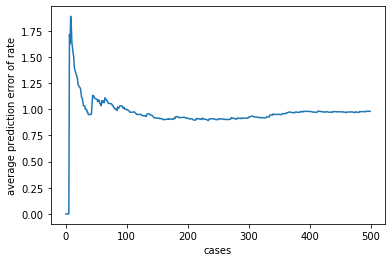

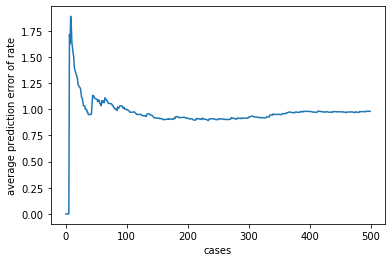

In [352]:
plt.plot(diff)
plt.ylabel('average prediction error of rate')
plt.xlabel('cases')
plt.show()

In [346]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer

import copy
import operator
import datetime
import warnings
from itertools import product
warnings.filterwarnings("ignore")

TRAIN_SIZE = 100000
#we'll not be using the full training set, change this parameter if you wish to use more/less
train = pd.read_csv("interactions_train.csv")
validation = pd.read_csv("interactions_validation.csv")
raw = pd.read_csv("RAW_recipes.csv")
r_calory = pd.read_csv("PP_recipes.csv")
raw = raw.rename({"id":"recipe_id"},axis=1)
interactions_RAW = pd.read_csv("RAW_interactions.csv")

#since we'll be using k-fold validation, there is not need to use a seperate validation set
train = pd.concat([train,validation],axis=0)
test = pd.read_csv("interactions_test.csv")
train = train.iloc[:TRAIN_SIZE,:]

train = train.merge(interactions_RAW.drop(["date"],axis=1),on=["user_id","recipe_id"])
train = train.merge(raw,on="recipe_id")
test = test.merge(interactions_RAW.drop(["date"],axis=1),on=["user_id","recipe_id"])
test = test.merge(raw,on="recipe_id")
train.head(2)

raw1=pd.merge(raw,r_calory,left_on="recipe_id",right_on="id",how="right")
raw1.head(2)

interactions_RAW.head(2)

interactions_RAW.drop(['user_id', 'date','review'],axis=1)

raw1.drop(['name','contributor_id','submitted','steps','description','ingredient_ids','i','name_tokens','ingredient_tokens','steps_tokens','techniques','id'], axis=1)

raw1['recipe_id']

raw1_train = raw1.iloc[0:5000]
raw1_test = raw1.iloc[50000:60000]
raw1_train.drop(['name','contributor_id','submitted','steps','description','ingredient_ids','i','name_tokens','ingredient_tokens','steps_tokens','techniques','id'], axis=1)
raw1_test.drop(['name','contributor_id','submitted','steps','description','ingredient_ids','i','name_tokens','ingredient_tokens','steps_tokens','techniques','id'], axis=1)

raw1_train['recipe_id']

raw1_test['recipe_id']

id_list = list(raw1_train['recipe_id'])
minutes_list = list(raw1_train['minutes'])
tags_list = list(raw1_train['tags'])
nutrition_list = list(raw1_train['nutrition'])
n_steps_list = list(raw1_train['n_steps'])
ingredients_list = list(raw1_train['ingredients'])
n_ingredients_list = list(raw1_train['n_ingredients'])
calorie_level_list = list(raw1_train['calorie_level'])
rate_list_id = list(interactions_RAW['recipe_id'])
rate_list = list(interactions_RAW['rating'])

def getRate(recipe_id):
    sum = 0.0
    occ = 0
    for i in range(len(rate_list_id)):
      if rate_list_id[i] == recipe_id:
        sum += rate_list[i]
        occ += 1
    return sum / occ

def matched(recipe_id, minutes, tags, nutrition, n_steps, ingredients, n_ingredients, calorie_level):
  highest_matched = 0.0
  rate = 0.0
  exists = False
    
  if recipe_id in id_list:
    rate = getRate(recipe_id)
    exists = True
  else:
    tolerance_nutri = [5.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
    tolerance_minutes = 2.0
    tolerance_n_steps = 2.0
    tolerance_n_ingredients = 1.0
    tolerance_cal_level = 1.0
    for i in range(len(id_list)):
      matched_ingrdient = 0.0
      matched_tags = 0.0
      matched_nutrition = 0.0
      matched_mins = 0
      matched_n_steps = 0
      matched_n_ingredients = 0
      matched_calorie_level = 0

      ingredi = ingredients[1:-1]
      ingredis = ingredi.split(", ")
      ingredi_list = ingredients_list[i][1:-1]
      ingredi_lists = ingredi_list.split(", ")

      n_ing = 0
      for ing in ingredis:
        if ing in ingredi_lists:
          n_ing += 1
      matched_ingrdient = n_ing / n_ingredients_list[i]

      tagge = tags[1:-1]
      tagges = tagge.split(", ")
      tagge_list = tags_list[i][1:-1]
      tagge_lists = tagge_list.split(", ")

      n_tags = 0
      for t in tagges:
        if t in tagge_lists:
          n_tags += 1
      matched_tags = n_tags / len(tagge_lists)

      if abs(minutes - minutes_list[i]) <= tolerance_minutes:
        matched_mins = 1
      if abs(n_steps - n_steps_list[i]) <= tolerance_n_steps:
        matched_n_steps = 1
      if abs(n_ingredients - n_ingredients_list[i]) <= tolerance_n_ingredients:
        matched_n_ingredients = 1
      if abs(calorie_level - calorie_level_list[i]) <= tolerance_cal_level:
        matched_calorie_level = 1

      matched = 0.5 * matched_ingrdient + 0.30 * matched_tags + 0.05 * (matched_mins + matched_n_steps + matched_n_ingredients + matched_calorie_level)
      if matched > highest_matched:
        highest_matched = matched
        rate = getRate(id_list[i])
  if not exists:
    id_list.append(recipe_id)
    minutes_list.append(minutes)
    tags_list.append(tags)
    nutrition_list.append(nutrition)
    n_steps_list.append(n_steps)
    ingredients_list.append(ingredients)
    n_ingredients_list.append(n_ingredients)
    calorie_level_list.append(calorie_level)
  rate_list_id.append(recipe_id)
  rate_list.append(rate)
  return rate

def plotCurve2line(predict, accuracy, file_path, xLabel, yLabel, title, label1, label2, rangeL, rangeR, seq):
    x = np.arange(rangeL, rangeR, seq)
    plt.plot(x, predict, label=label1)
    plt.plot(x, accuracy, label=label2)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    plt.savefig(file_path)
    plt.show()
    plt.clf()

def plotCurve(diff, file_path, xLabel, yLabel, title, label, rangeL, rangeR, seq):
    x = np.arange(rangeL, rangeR, seq)
    plt.plot(x, diff, label=label)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    plt.savefig(file_path)
    plt.show()
    plt.clf()

def plotCurveavg(diff, file_path, xLabel, yLabel, title, label, rangeL, rangeR, seq):
    x = np.arange(rangeL, rangeR, seq)
    plt.plot(x, diff, label=label)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    plt.ylim([0.5, 1])
    plt.savefig(file_path)
    plt.show()
    plt.clf()

def test():
  predict = []
  actually = []
  diffc = []
  avg_err = []
  sum_err = 0.0
  num = 0

  test_id_list = list(raw1_test['recipe_id'])
  test_minutes_list = list(raw1_test['minutes'])
  test_tags_list = list(raw1_test['tags'])
  test_nutrition_list = list(raw1_test['nutrition'])
  test_n_steps_list = list(raw1_test['n_steps'])
  test_ingredients_list = list(raw1_test['ingredients'])
  test_n_ingredients_list = list(raw1_test['n_ingredients'])
  test_calorie_level_list = list(raw1_test['calorie_level'])

  for i in range(len(test_id_list)):
    print(i)
    rate_actually = getRate(test_id_list[i])
    actually.append(rate_actually)
    rate = matched(test_id_list[i], test_minutes_list[i], test_tags_list[i], test_nutrition_list[i], test_n_steps_list[i], test_ingredients_list[i], test_n_ingredients_list[i], test_calorie_level_list[i])
    predict.append(rate)
    diff = abs(rate_actually - rate)
    diffc.append(diff)
    sum_err += diff
    num += 1
    avg_e = sum_err / num
    avg_err.append(avg_e)
  plotCurve2line(predict, actually, "comparison.png", "cases", "rate", "prediction of rate comparsion", "predict", "actually", 0, 10000, 1)
  plotCurve(diffc, "error difference", "cases", "error difference", "prediction error of rate", "difference", 0, 10000, 1)
  plotCurveavg(avg_err, "avg error difference", "cases", "avg error difference", "avg prediction error of rate", "avg difference", 0, 10000, 1)
  return avg_err

In [347]:
test()

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


KeyboardInterrupt: 

KeyboardInterrupt: 